<a href="https://colab.research.google.com/github/Ni7070/NumtaDbBanglaDigitRecognizer/blob/main/Numtadb_Deep_NN(new).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset


import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image

import os
from os import path
import shutil
import glob

In [2]:
!pip install kaggle

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"tahiranishat","key":"8ed924ff655cd5b32f597aa3e24be0fa"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d BengaliAI/numta

 99% 1.90G/1.91G [00:24<00:00, 85.5MB/s]
100% 1.91G/1.91G [00:24<00:00, 83.5MB/s]


In [6]:
from zipfile import ZipFile
file_name = "numta.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print("Done!")

Done!


In [7]:
#read CSV files only filename and digit column
trainA =pd.read_csv('/content/training-a.csv', usecols = ['filename', 'digit'])
trainB =pd.read_csv('/content/training-a.csv', usecols = ['filename', 'digit'])
trainC =pd.read_csv('/content/training-a.csv', usecols = ['filename', 'digit'])
trainD =pd.read_csv('/content/training-a.csv', usecols = ['filename', 'digit'])
trainE =pd.read_csv('/content/training-a.csv', usecols = ['filename', 'digit'])

In [ ]:
print(trainA.columns)
print(trainB.columns)
print(trainC.columns)
print(trainD.columns)
print(trainE.columns)

Index(['filename', 'digit'], dtype='object')
Index(['filename', 'digit'], dtype='object')
Index(['filename', 'digit'], dtype='object')
Index(['filename', 'digit'], dtype='object')
Index(['filename', 'digit'], dtype='object')


In [8]:
merged_csv = pd.concat(([trainA, trainB, trainC, trainD, trainE]))
print(len(merged_csv))
print(merged_csv.tail())

98510
         filename  digit
19697  a19697.png      4
19698  a19698.png      3
19699  a19699.png      8
19700  a19700.png      3
19701  a19701.png      8


In [9]:
TRAIN_PATH = "trainAllNumtadb"
PATH = '/content/'

In [10]:
os.mkdir(TRAIN_PATH)

In [11]:
def processImages(folder_name):
  src = PATH + folder_name + '/'
  dir_folders = os.listdir(src)
  for dir_name in dir_folders:
    file_name = os.path.join(src, dir_name)
    if os.path.isfile(file_name):
      shutil.copy(file_name, TRAIN_PATH)

In [12]:
processImages('training-a')
print('A Done')
processImages('training-b')
print('B Done')
processImages('training-c')
print('C Done')
processImages('training-d')
print('D Done')
processImages('training-e')
print('E Done')

A Done
B Done
C Done
D Done
E Done


In [14]:
class numtaDb(Dataset):
    def __init__(self, merged_csv_file, root_dir, transform=None):
        self.data = merged_csv_file
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        item = self.data.iloc[index]
        path = self.root_dir + '/' + item[0]
        image = Image.open(path).convert('L')
        label = item[1]
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label

In [16]:
mean = [0.5,]
std = [0.5, ]

dset_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
    
])
'''
LOADING DATASET
'''
dataset = numtaDb(merged_csv_file = merged_csv, root_dir = TRAIN_PATH, 
                            #train=True, 
                            transform = dset_transform # Normalize the image to [0-1] from [0-255]
                            )


In [17]:
#split data into train:test = 90:10
from sklearn.model_selection import train_test_split
train_dataset, test_dataset = train_test_split(dataset, test_size=0.1)

###Settings: 01

In [19]:
# Hyperparameters for settings 1 accuracy 79.72794640138056%
batch_size = 260
num_iters = 30000
input_dim = 28*28 # num_features = 784
num_hidden = 200
output_dim = 10

learning_rate = 0.004

num_epochs = num_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)


# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True
                                           )  

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False) 

class NeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
        ### 1st hidden layer:
        self.linear_1 = nn.Linear(784, num_hidden)
        ### Non-linearity in 1st hidden layer
        self.tanh = nn.Tanh()

        ### 2nd hidden layer: 
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 2nd hidden layer
        self.leaky_relu_1 = nn.LeakyReLU()

        ### 3rd hidden layer: 
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 3rd hidden layer
        self.relu_1 = nn.ReLU6()

        ### 4th hidden layer: 
        self.linear_4 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 3rd hidden layer
        self.relu_2 = nn.ReLU6()

        ### 5th hidden layer: 
        self.linear_5 = nn.Linear(num_hidden, num_hidden)
        self.sigmoid = nn.Sigmoid()

        ### Output layer: 
        self.linear_out = nn.Linear(num_hidden, num_classes)

    def forward(self, x):
        ## 1st hidden layer
        out  = self.linear_1(x)
        ### Non-linearity in 1st hidden layer
        out = self.tanh(out)
        
        ### 2nd hidden layer
        out  = self.linear_2(out)
        ### Non-linearity in 2nd hidden layer
        out = self.leaky_relu_1(out)

        ### 3rd hidden layer
        out  = self.linear_3(out)
        ### Non-linearity in 3rd hidden layer
        out = self.relu_1(out)

        ### 4th hidden layer
        out  = self.linear_4(out)
        ### Non-linearity in 4th hidden layer
        out = self.relu_2(out)

        ### 5th hidden layer
        out  = self.linear_5(out)
        ### Non-linearity in 5th hidden layer
        out = self.sigmoid(out)
        
        # Linear layer (output)
        #probas  = self.linear_out(out)
        logits  = self.linear_out(out)
        probas = F.softmax(logits, dim=1)
        return probas

model = NeuralNetworkModel(input_size = input_dim,
                           num_classes = output_dim,
                           num_hidden = num_hidden)
# To enable GPU
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adagrad(model.parameters(), lr=learning_rate)

'''
TRAIN THE MODEL
'''
iteration_loss = []
iter = 0
p = []
l = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images.float()) 

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1
        #print(iter)

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                outputs = model(images.float())

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)

                # Total number of labels
                total += labels.size(0)

                pt = predicted.cpu()
                lt = labels.cpu()
                #taking all predicted label into a list
                p.append(pt)
                #taking all real label into a list
                l.append(lt)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))
            

Iteration: 500. Loss: 2.250267744064331. Accuracy: 20.05887727134301
Iteration: 1000. Loss: 2.1314291954040527. Accuracy: 32.52461679017359
Iteration: 1500. Loss: 2.0553860664367676. Accuracy: 39.05187290630393
Iteration: 2000. Loss: 2.074219226837158. Accuracy: 41.67089635569993
Iteration: 2500. Loss: 2.006260633468628. Accuracy: 47.26423713328596
Iteration: 3000. Loss: 1.9877510070800781. Accuracy: 53.212871789666025
Iteration: 3500. Loss: 1.9848003387451172. Accuracy: 53.903157039894424
Iteration: 4000. Loss: 1.8649343252182007. Accuracy: 57.30382702263729
Iteration: 4500. Loss: 1.8655245304107666. Accuracy: 59.059993909247794
Iteration: 5000. Loss: 1.863340139389038. Accuracy: 58.58288498629581
Iteration: 5500. Loss: 1.8450742959976196. Accuracy: 62.25763881839407
Iteration: 6000. Loss: 1.805406928062439. Accuracy: 63.699116840929854
Iteration: 6500. Loss: 1.8373420238494873. Accuracy: 69.27215511115622
Iteration: 7000. Loss: 1.770908236503601. Accuracy: 72.93675768957466
Iteration

[2.250267744064331, 2.1314291954040527, 2.0553860664367676, 2.074219226837158, 2.006260633468628, 1.9877510070800781, 1.9848003387451172, 1.8649343252182007, 1.8655245304107666, 1.863340139389038, 1.8450742959976196, 1.805406928062439, 1.8373420238494873, 1.770908236503601, 1.732114553451538, 1.7286102771759033, 1.7463862895965576, 1.7326947450637817, 1.736188530921936, 1.6772714853286743, 1.696804165840149, 1.7361496686935425, 1.670790195465088, 1.6649523973464966, 1.6549079418182373, 1.7527457475662231, 1.6861050128936768, 1.6062372922897339, 1.6389456987380981, 1.6597096920013428, 1.6273770332336426, 1.6297653913497925, 1.6352214813232422, 1.6757164001464844, 1.6340779066085815, 1.611755609512329, 1.6087738275527954, 1.6028733253479004, 1.618937611579895, 1.6081771850585938, 1.583968162536621, 1.6069236993789673, 1.620898723602295, 1.590957522392273, 1.5984982252120972, 1.6242859363555908, 1.6239992380142212, 1.6032841205596924, 1.5447056293487549, 1.6000685691833496, 1.569511532783

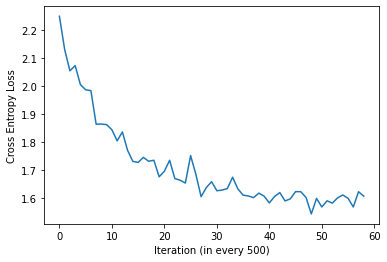

In [20]:
import matplotlib
import matplotlib.pyplot as plt

print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 500)')
plt.show()

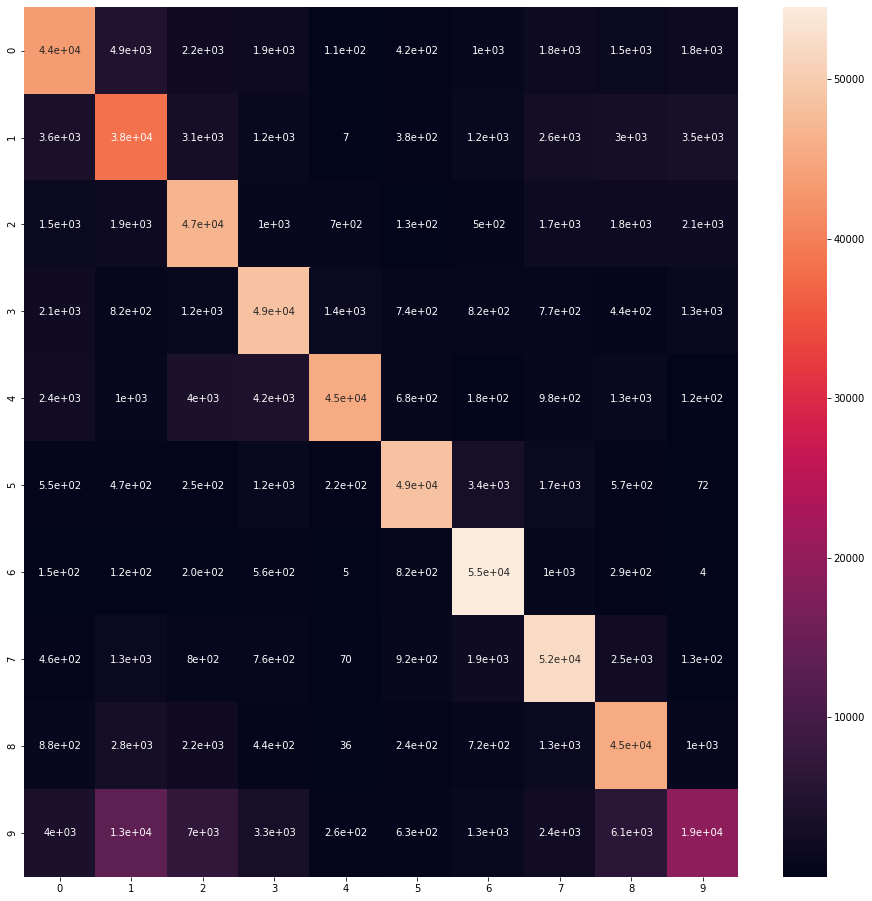

In [21]:
import itertools
import seaborn as sns


#flatten predicted labels and real labels
flatten_l = list(itertools.chain.from_iterable(l))
flatten_p = list(itertools.chain.from_iterable(p))

fig, ax = plt.subplots(figsize=(16, 16))
from sklearn.metrics import confusion_matrix
# Confusion matrix
conf_mat=confusion_matrix(flatten_l, flatten_p)
# print(conf_mat)
sns.heatmap(conf_mat, annot=True)

In [23]:
from sklearn.metrics import classification_report
print(classification_report(flatten_l, flatten_p))

              precision    recall  f1-score   support

           0       0.74      0.74      0.74     59236
           1       0.59      0.67      0.63     56699
           2       0.69      0.80      0.74     58115
           3       0.77      0.83      0.80     58410
           4       0.94      0.75      0.84     60239
           5       0.91      0.85      0.88     57053
           6       0.83      0.94      0.88     57702
           7       0.78      0.85      0.82     60888
           8       0.72      0.82      0.77     55106
           9       0.66      0.34      0.45     57761

    accuracy                           0.76    581209
   macro avg       0.76      0.76      0.75    581209
weighted avg       0.76      0.76      0.75    581209



In [25]:
#colab mount
from google.colab import drive
#drive.flush_and_unmount()
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [26]:
root_path = "/content/gdrive/MyDrive/Colab Notebooks/pickle Files/"
save_model = True
if save_model is True:
    # Saves only parameters
    # wights & biases
    torch.save(model.state_dict(), root_path + 'numtadbnn1.pkl')

Settings: 02

In [29]:
# Hyperparameters for settings 2 accuracy 89.55435996345548%
batch_size = 250
num_iters = 15000
input_dim = 28*28 # num_features = 784
num_hidden = 180
output_dim = 10

learning_rate = 0.001

num_epochs = num_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)


# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True
                                           )  

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False) 

class NeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
        ### 1st hidden layer: 
        self.linear_1 = nn.Linear(784, num_hidden)
        ### Non-linearity in 1st hidden layer
        self.relu_1 = nn.LeakyReLU()

        ### 2nd hidden layer: 
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 2nd hidden layer
        self.leaky_relu_1 = nn.ReLU6()

        ### 3rd hidden layer: 
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 3rd hidden layer
        self.relu_3 = nn.ReLU6()

        ### 4th hidden layer: 
        self.linear_4 = nn.Linear(num_hidden, num_hidden)
        self.sigmoid = nn.Sigmoid()

        ### Output layer: 
        self.linear_out = nn.Linear(num_hidden, num_classes)

    def forward(self, x):
        ## 1st hidden layer
        out  = self.linear_1(x)
        ### Non-linearity in 1st hidden layer
        out = self.relu_1(out)
        
        ### 2nd hidden layer
        out  = self.linear_2(out)
        ### Non-linearity in 2nd hidden layer
        out = self.leaky_relu_1(out)

        ### 3rd hidden layer
        out  = self.linear_3(out)
        ### Non-linearity in 3rd hidden layer
        out = self.relu_3(out)

        ### 4th hidden layer
        out  = self.linear_4(out)
        ### Non-linearity in 3rd hidden layer
        out = self.sigmoid(out)
        
        # Linear layer (output)
        #probas  = self.linear_out(out)
        logits  = self.linear_out(out)
        probas = F.softmax(logits, dim=1)
        return probas

model = NeuralNetworkModel(input_size = input_dim,
                           num_classes = output_dim,
                           num_hidden = num_hidden)
# To enable GPU
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adamax(model.parameters(), lr=learning_rate)

'''
TRAIN THE MODEL
'''
iteration_loss = []
iter = 0
p = []
l = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images.float()) 

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1
        # print(iter)

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                outputs = model(images.float())

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)

                # Total number of labels
                total += labels.size(0)
                pt = predicted.cpu()
                lt = labels.cpu()
                #taking all predicted label into a list
                p.append(pt)
                #taking all real label into a list
                l.append(lt)

                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 2.222869634628296. Accuracy: 23.967109938077353
Iteration: 1000. Loss: 2.1644179821014404. Accuracy: 26.352654552837276
Iteration: 1500. Loss: 2.165560483932495. Accuracy: 31.225256319155417
Iteration: 2000. Loss: 2.049304723739624. Accuracy: 44.574154908131156
Iteration: 2500. Loss: 1.9549965858459473. Accuracy: 52.969241701350114
Iteration: 3000. Loss: 1.865670084953308. Accuracy: 60.99888336209522
Iteration: 3500. Loss: 1.8333107233047485. Accuracy: 64.38940209115826
Iteration: 4000. Loss: 1.7310051918029785. Accuracy: 70.9166582072886
Iteration: 4500. Loss: 1.7740850448608398. Accuracy: 72.00284235103035
Iteration: 5000. Loss: 1.6940481662750244. Accuracy: 76.01258755456298
Iteration: 5500. Loss: 1.6991040706634521. Accuracy: 77.50482184549791
Iteration: 6000. Loss: 1.7193188667297363. Accuracy: 79.84976144553852
Iteration: 6500. Loss: 1.6610809564590454. Accuracy: 80.99685311135926
Iteration: 7000. Loss: 1.7057559490203857. Accuracy: 79.52492132778399
Iterati

[2.222869634628296, 2.1644179821014404, 2.165560483932495, 2.049304723739624, 1.9549965858459473, 1.865670084953308, 1.8333107233047485, 1.7310051918029785, 1.7740850448608398, 1.6940481662750244, 1.6991040706634521, 1.7193188667297363, 1.6610809564590454, 1.7057559490203857, 1.7062592506408691, 1.6410558223724365, 1.6428083181381226, 1.6101219654083252, 1.6072665452957153, 1.588212013244629, 1.6189502477645874, 1.5419549942016602, 1.6083203554153442, 1.5963037014007568, 1.5837945938110352, 1.6015666723251343, 1.6075421571731567, 1.5989904403686523, 1.5787403583526611]


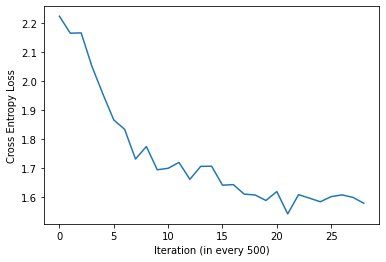

In [30]:
import matplotlib
import matplotlib.pyplot as plt

print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 500)')
plt.show()

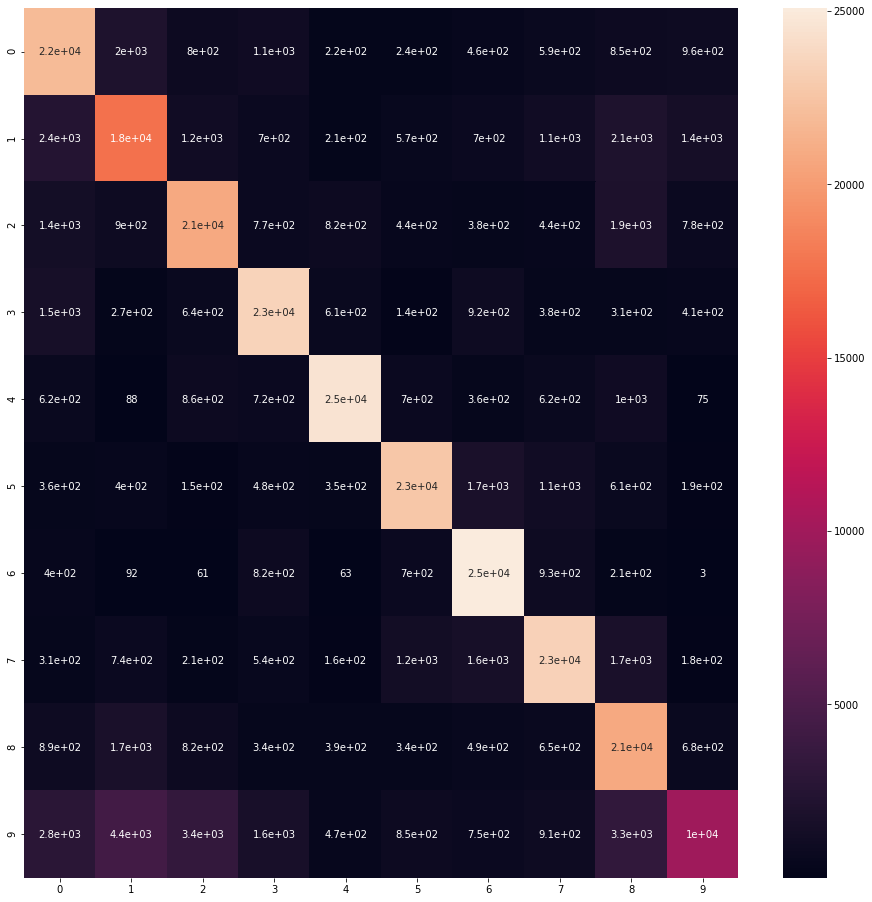

In [31]:
import itertools
import seaborn as sns


#flatten predicted labels and real labels
flatten_l = list(itertools.chain.from_iterable(l))
flatten_p = list(itertools.chain.from_iterable(p))

fig, ax = plt.subplots(figsize=(16, 16))
from sklearn.metrics import confusion_matrix
# Confusion matrix
conf_mat=confusion_matrix(flatten_l, flatten_p)
# print(conf_mat)
sns.heatmap(conf_mat, annot=True)

In [32]:
from sklearn.metrics import classification_report
print(classification_report(flatten_l, flatten_p))

              precision    recall  f1-score   support

           0       0.67      0.75      0.71     29116
           1       0.62      0.63      0.63     27869
           2       0.72      0.73      0.72     28565
           3       0.77      0.82      0.79     28710
           4       0.88      0.83      0.85     29609
           5       0.81      0.81      0.81     28043
           6       0.77      0.88      0.83     28362
           7       0.78      0.78      0.78     29928
           8       0.63      0.77      0.69     27086
           9       0.68      0.35      0.46     28391

    accuracy                           0.74    285679
   macro avg       0.73      0.74      0.73    285679
weighted avg       0.74      0.74      0.73    285679



In [33]:
root_path = "/content/gdrive/MyDrive/Colab Notebooks/pickle Files/"
save_model = True
if save_model is True:
    # Saves only parameters
    # wights & biases
    torch.save(model.state_dict(), root_path + 'numtadbnn2.pkl')

Settings: 03

In [34]:
# Hyperparameters for settings3 accuracy = 95.7973809765506%
batch_size = 256
num_iters = 30000
input_dim = 28*28 # num_features = 784
num_hidden = 180
output_dim = 10

learning_rate = 0.002

num_epochs = num_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)


# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True
                                           )  

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False) 

class NeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
        ### 1st hidden layer: 
        self.linear_1 = nn.Linear(784, num_hidden)
        ### Non-linearity in 1st hidden layer
        self.relu_1 = nn.LeakyReLU()

        ### 2nd hidden layer: 
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 2nd hidden layer
        self.leaky_relu_1 = nn.ReLU6()

        ### 3rd hidden layer: 
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 3rd hidden layer
        self.relu_3 = nn.ReLU6()

        ### 4th hidden layer: 
        self.linear_4 = nn.Linear(num_hidden, num_hidden)
        self.sigmoid = nn.Sigmoid()

        ### Output layer: 
        self.linear_out = nn.Linear(num_hidden, num_classes)

    def forward(self, x):
        ## 1st hidden layer
        out  = self.linear_1(x)
        ### Non-linearity in 1st hidden layer
        out = self.relu_1(out)
        
        ### 2nd hidden layer
        out  = self.linear_2(out)
        ### Non-linearity in 2nd hidden layer
        out = self.leaky_relu_1(out)

        ### 3rd hidden layer
        out  = self.linear_3(out)
        ### Non-linearity in 3rd hidden layer
        out = self.relu_3(out)

        ### 4th hidden layer
        out  = self.linear_4(out)
        ### Non-linearity in 3rd hidden layer
        out = self.sigmoid(out)
        
        # Linear layer (output)
        #probas  = self.linear_out(out)
        logits  = self.linear_out(out)
        probas = F.softmax(logits, dim=1)
        return probas

model = NeuralNetworkModel(input_size = input_dim,
                           num_classes = output_dim,
                           num_hidden = num_hidden)
# To enable GPU
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adamax(model.parameters(), lr=learning_rate)

'''
TRAIN THE MODEL
'''
iteration_loss = []
iter = 0
p = []
l = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images.float()) 

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1
        # print(iter)

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                outputs = model(images.float())

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)

                # Total number of labels
                total += labels.size(0)

                pt = predicted.cpu()
                lt = labels.cpu()
                #taking all predicted label into a list
                p.append(pt)
                #taking all real label into a list
                l.append(lt)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 2.143592596054077. Accuracy: 32.666734341691196
Iteration: 1000. Loss: 1.9726262092590332. Accuracy: 48.23875748654959
Iteration: 1500. Loss: 1.9328361749649048. Accuracy: 56.014617805298954
Iteration: 2000. Loss: 1.8936913013458252. Accuracy: 59.821337935235
Iteration: 2500. Loss: 1.8031203746795654. Accuracy: 58.420464927418536
Iteration: 3000. Loss: 1.8338600397109985. Accuracy: 64.08486448076337
Iteration: 3500. Loss: 1.745190143585205. Accuracy: 72.86569891381586
Iteration: 4000. Loss: 1.6981343030929565. Accuracy: 71.51558217439853
Iteration: 4500. Loss: 1.70472252368927. Accuracy: 75.02791594761953
Iteration: 5000. Loss: 1.6869730949401855. Accuracy: 75.82986498832607
Iteration: 5500. Loss: 1.7022780179977417. Accuracy: 81.70744086894732
Iteration: 6000. Loss: 1.6841753721237183. Accuracy: 81.31154197543397
Iteration: 6500. Loss: 1.6572213172912598. Accuracy: 83.53466653131662
Iteration: 7000. Loss: 1.724094033241272. Accuracy: 83.70723784387371
Iteration: 

[2.143592596054077, 1.9726262092590332, 1.9328361749649048, 1.8936913013458252, 1.8031203746795654, 1.8338600397109985, 1.745190143585205, 1.6981343030929565, 1.70472252368927, 1.6869730949401855, 1.7022780179977417, 1.6841753721237183, 1.6572213172912598, 1.724094033241272, 1.6320765018463135, 1.6519745588302612, 1.5935838222503662, 1.6168951988220215, 1.603558897972107, 1.58029305934906, 1.6266754865646362, 1.5892081260681152, 1.6139801740646362, 1.5701453685760498, 1.6735299825668335, 1.5538209676742554, 1.5550448894500732, 1.5781060457229614, 1.550911545753479, 1.5968118906021118, 1.521713137626648, 1.5470250844955444, 1.5972346067428589, 1.5218546390533447, 1.5401901006698608, 1.516832709312439, 1.540021538734436, 1.5355664491653442, 1.5115447044372559, 1.500143051147461, 1.531968355178833, 1.5307846069335938, 1.5186386108398438, 1.5216399431228638, 1.5401716232299805, 1.5081819295883179, 1.5513811111450195, 1.5256881713867188, 1.5280053615570068, 1.5058225393295288, 1.50725817680

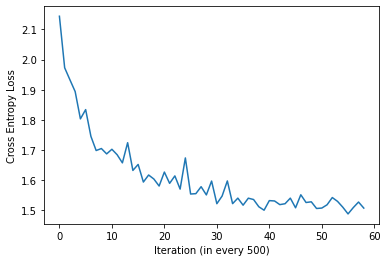

In [39]:
import matplotlib
import matplotlib.pyplot as plt

print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 500)')
plt.show()

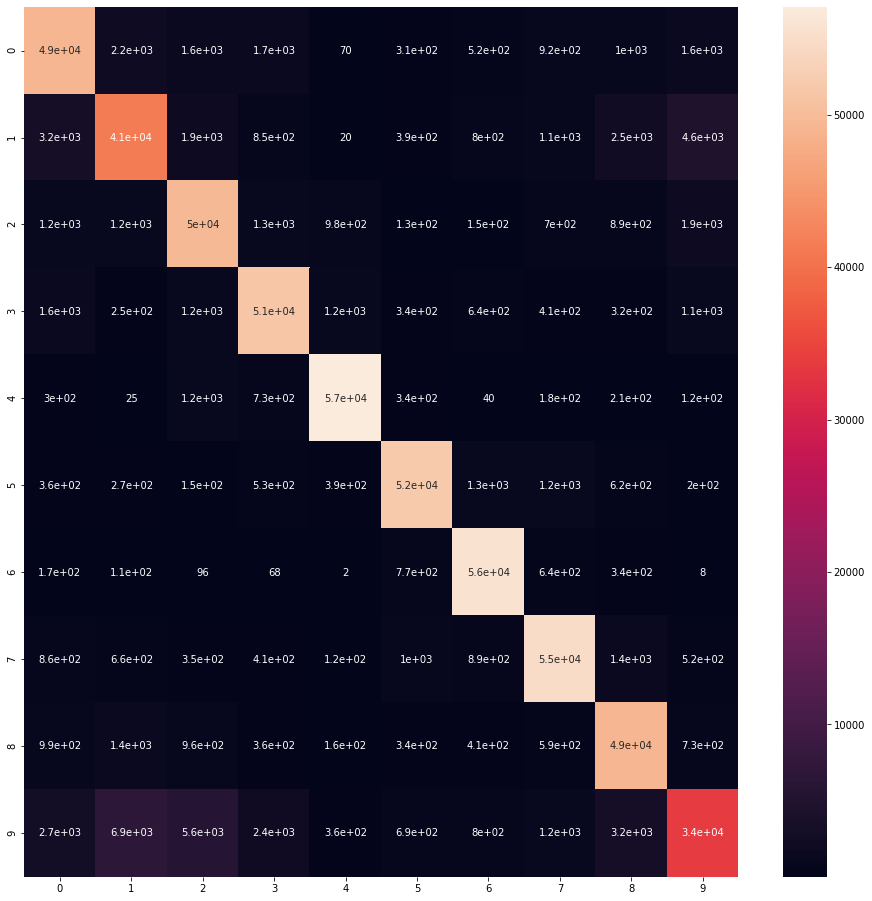

In [36]:
import itertools
import seaborn as sns


#flatten predicted labels and real labels
flatten_l = list(itertools.chain.from_iterable(l))
flatten_p = list(itertools.chain.from_iterable(p))

fig, ax = plt.subplots(figsize=(16, 16))
from sklearn.metrics import confusion_matrix
# Confusion matrix
conf_mat=confusion_matrix(flatten_l, flatten_p)
# print(conf_mat)
sns.heatmap(conf_mat, annot=True)

In [37]:
from sklearn.metrics import classification_report
print(classification_report(flatten_l, flatten_p))

              precision    recall  f1-score   support

           0       0.81      0.83      0.82     59236
           1       0.76      0.73      0.75     56699
           2       0.79      0.85      0.82     58115
           3       0.86      0.88      0.87     58410
           4       0.95      0.95      0.95     60239
           5       0.92      0.91      0.92     57053
           6       0.91      0.96      0.93     57702
           7       0.89      0.90      0.89     60888
           8       0.82      0.89      0.86     55106
           9       0.76      0.59      0.66     57761

    accuracy                           0.85    581209
   macro avg       0.85      0.85      0.85    581209
weighted avg       0.85      0.85      0.85    581209



In [38]:
root_path = "/content/gdrive/MyDrive/Colab Notebooks/pickle Files/"
save_model = True
if save_model is True:
    # Saves only parameters
    # wights & biases
    torch.save(model.state_dict(), root_path + 'numtadbnn3.pkl')

# **ID: 16.02.04.070**
# **New**
# **Problem #1**

# **Setings 1:**
Linear1->Tanh->Linear2->LeakyReLU->Linear3->Relu6->Linear4->Relu6->Linear5->Sigmoid
# **Setings 2:**
Linear1->LeakyReLU->Linear2->Relu6->Linear3->Relu6->Linear4->Sigmoid
# **Setings 3:**
Linear1->LeakyReLU->Linear2->Relu6->Linear3->Relu6->Linear4->Sigmoid


No.|batch_size | num_iters | learning rate|optimizer|hidden layer Dim|Accuracy
---|---|---|---|---|---|---|
1|260|30,000|0.004|Adagrad|200|76%
2|250|15,000|0.001|Adamax|180|74%
3|256|30,000|0.002|Adamax|180|85%
